# Vizualization of the graphs and anomalies

This notebook is made for vizualizing the graphs and anomalies injected

In [6]:
# Load the extension
%load_ext autoreload
# Configure it to reload all modules before each cell execution
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import custom modules
from src.data.dataloader import load_member_features, load_provider_features, load_claims_data, prepare_hetero_data
from src.data.anomaly_injection import *
from src.models.main_model import BipartiteGraphAutoEncoder
from src.models.baseline_models import MLPAutoencoder, SklearnBaseline, GCNAutoencoder, GATAutoencoder, SAGEAutoencoder
from src.utils.train_utils import train_model
from src.utils.eval_utils import evaluate_anomaly_detection, plot_precision_recall_curves, plot_anomaly_distribution, compare_models
from src.utils.vizualize import *

In [11]:
# Load and prepare data
df_member_features, members_dataset = load_member_features("../data/final_members_df.pickle")
df_provider_features, providers_dataset = load_provider_features("../data/final_df.pickle")
df_edges = load_claims_data("../data/df_descriptions.pickle", members_dataset, providers_dataset)
clean_data = prepare_hetero_data(df_member_features, df_provider_features, df_edges)

In [17]:
def visualize_feature_anomalies(data, labels, anomaly_tracking=None, node_type='provider', max_nodes=10):
    """
    Visualize feature differences between normal and anomalous nodes.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get indices of anomalous and normal nodes
    anomaly_indices = torch.where(labels[node_type] == 1)[0].tolist()
    normal_indices = torch.where(labels[node_type] == 0)[0].tolist()
    
    # Sample a subset if too many
    if len(anomaly_indices) > max_nodes:
        anomaly_indices = np.random.choice(anomaly_indices, max_nodes, replace=False).tolist()
    if len(normal_indices) > max_nodes:
        normal_indices = np.random.choice(normal_indices, max_nodes, replace=False).tolist()
    
    # Extract features
    anomaly_features = data[node_type].x[anomaly_indices].cpu().numpy()
    normal_features = data[node_type].x[normal_indices].cpu().numpy()
    
    # Determine number of features to plot
    n_features = min(8, anomaly_features.shape[1])
    
    # Create plot
    plt.figure(figsize=(15, 10))
    for i in range(n_features):
        plt.subplot(2, 4, i+1)
        plt.boxplot([normal_features[:, i], anomaly_features[:, i]], labels=['Normal', 'Anomaly'])
        plt.title(f'Feature {i}')
    
    plt.tight_layout()
    plt.suptitle(f'Feature Comparison for {node_type.capitalize()} Nodes')
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # If tracking is provided, show anomaly types
    if anomaly_tracking:
        if node_type in anomaly_tracking:
            print("\nAnomaly types:")
            for idx in anomaly_indices:
                if idx in anomaly_tracking[node_type]:
                    types = anomaly_tracking[node_type][idx]
                    print(f"Node {idx}: {types}")


In [ ]:
# Test feature anomalies
feature_data, feature_labels, feature_tracking = inject_feature_anomalies_with_tracking(
    clean_data.clone(), percentage=0.04, anomaly_types=['outliers', 'correlations', 'patterns']
)



Injected 520 member anomalies
Injected 22 provider anomalies


Injected 520 member anomalies
Injected 22 provider anomalies


/var/folders/w5/nkdt1g454nb90009cv7387mr0000gn/T/ipykernel_12779/2398342196.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_features[:, i], anomaly_features[:, i]], labels=['Normal', 'Anomaly'])
/var/folders/w5/nkdt1g454nb90009cv7387mr0000gn/T/ipykernel_12779/2398342196.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_features[:, i], anomaly_features[:, i]], labels=['Normal', 'Anomaly'])
/var/folders/w5/nkdt1g454nb90009cv7387mr0000gn/T/ipykernel_12779/2398342196.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_features[:, i], anomaly_features[:, 

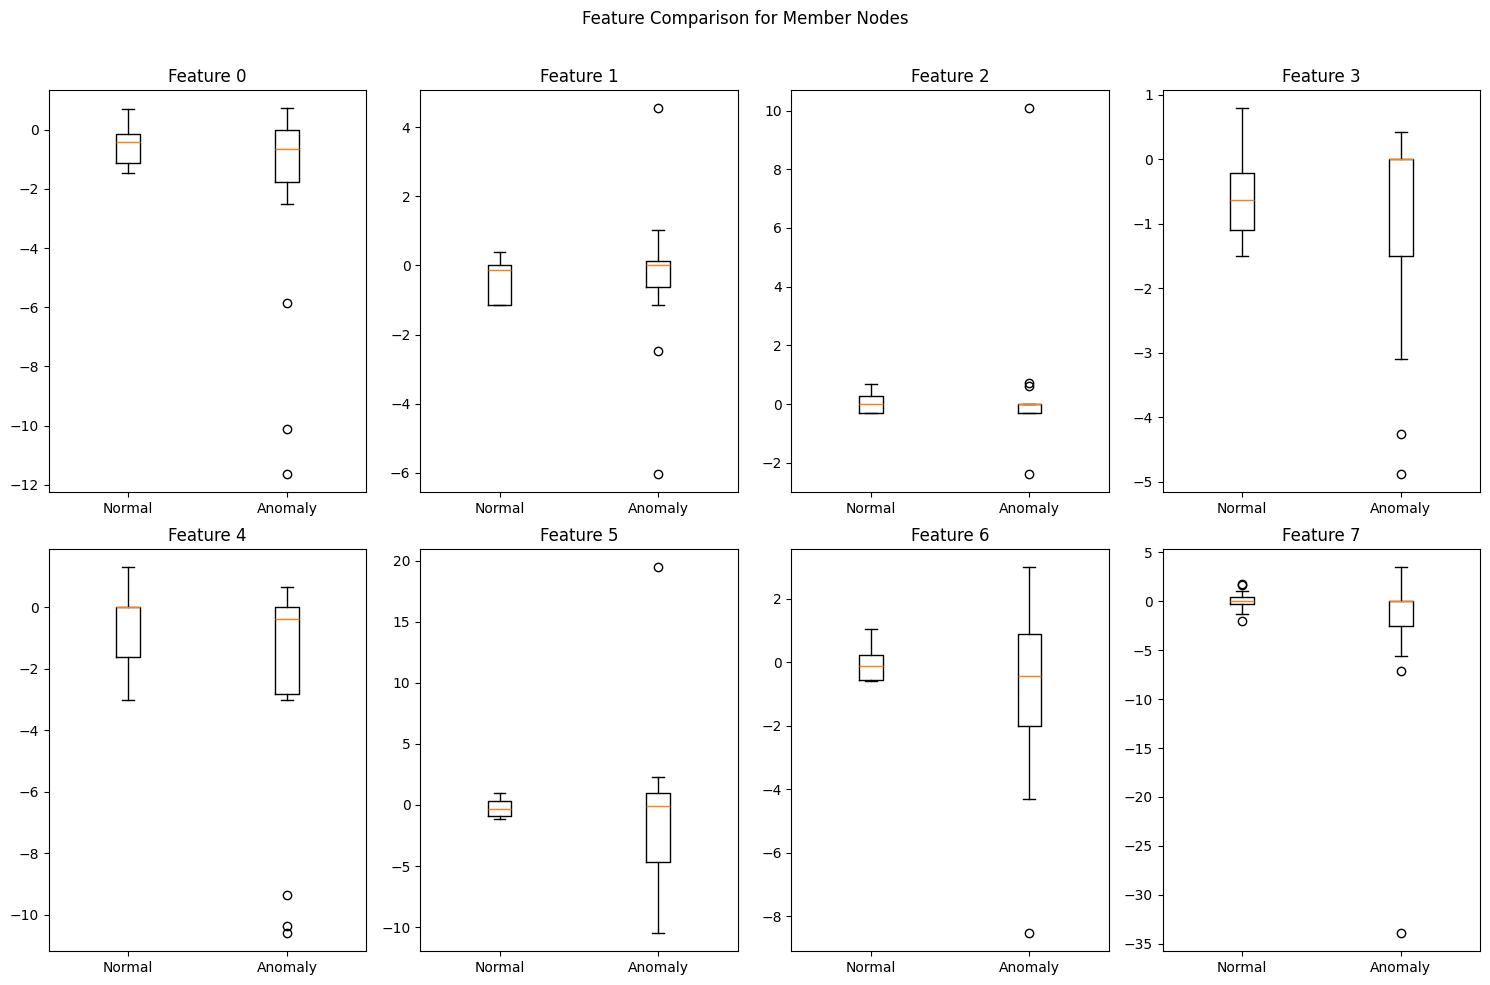


Anomaly types:
Node 27551: outliers
Node 31682: outliers
Node 6738: outliers
Node 8909: outliers
Node 2476: outliers
Node 24710: outliers
Node 17591: outliers
Node 26781: outliers
Node 27304: outliers
Node 24514: outliers
Node 16486: outliers
Node 25227: outliers
Node 31368: outliers
Node 32069: outliers
Node 22830: outliers


In [20]:
# Print summary stats
print(f"Injected {feature_labels['member'].sum().item()} member anomalies")
print(f"Injected {feature_labels['provider'].sum().item()} provider anomalies")

# Visualize feature anomalies
visualize_feature_anomalies(
    feature_data,
    feature_labels,
    anomaly_tracking=feature_tracking,
    node_type='member',
    max_nodes=15
)

In [9]:
# Load and prepare data
df_member_features, members_dataset = load_member_features("../data/final_members_df.pickle")
df_provider_features, providers_dataset = load_provider_features("../data/final_df.pickle")
df_edges = load_claims_data("../data/df_descriptions.pickle", members_dataset, providers_dataset)
data = prepare_hetero_data(df_member_features, df_provider_features, df_edges)

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Inject anomalies with tracking
print("Injecting anomalies with tracking...")
modified_data, gt_labels, anomaly_tracking = inject_mixed_anomalies_with_tracking(
    data, 
    percentages={'structural': 0.03, 'feature': 0.04, 'healthcare': 0.03},
    methods=['structural', 'feature', 'healthcare']
)

# Print statistics about injected anomalies
print(f"Injected {gt_labels['member'].sum().item()} member anomalies")
print(f"Injected {gt_labels['provider'].sum().item()} provider anomalies")

# Display anomaly type distribution
print("\nAnomaly type distribution:")
member_type_counts = {}
provider_type_counts = {}

for idx, types in anomaly_tracking['member'].items():
    for anomaly_type in types:
        member_type_counts[anomaly_type] = member_type_counts.get(anomaly_type, 0) + 1

for idx, types in anomaly_tracking['provider'].items():
    for anomaly_type in types:
        provider_type_counts[anomaly_type] = provider_type_counts.get(anomaly_type, 0) + 1

print("Member anomaly types:")
for anomaly_type, count in member_type_counts.items():
    print(f"  {anomaly_type}: {count}")

print("Provider anomaly types:")
for anomaly_type, count in provider_type_counts.items():
    print(f"  {anomaly_type}: {count}")


Injecting anomalies with tracking...


NameError: name 'df_provider_features' is not defined

In [ ]:

# Train your anomaly detection model
# For demonstration, let's assume your trained model is in 'model'
# and has been trained on the modified_data

# Evaluate the model
results = evaluate_anomaly_detection(model, modified_data, gt_labels)

print("\nOverall model performance:")
for node_type, metrics in results.items():
    print(f"{node_type}: AUC={metrics['auc']:.4f}, AP={metrics['ap']:.4f}")

# Now let's visualize the results

# 1. Visualize the graph with anomalies highlighted
print("\nGenerating graph visualization...")
net = visualize_anomaly_graph(
    modified_data, 
    gt_labels=gt_labels, 
    anomaly_tracking=anomaly_tracking,
    sample_size=50,  # Adjust based on your graph size
    filename='healthcare_anomalies.html'
)
# Note: In a Jupyter notebook, you can display the visualization with: net.show('healthcare_anomalies.html')
print(f"Graph visualization saved to healthcare_anomalies.html")

# 2. Visualize feature anomalies
print("\nGenerating feature anomaly visualizations...")
visualize_feature_anomalies(
    modified_data, 
    gt_labels, 
    anomaly_tracking=anomaly_tracking,
    node_type='provider',
    max_nodes=30
)

visualize_feature_anomalies(
    modified_data, 
    gt_labels, 
    anomaly_tracking=anomaly_tracking,
    node_type='member',
    max_nodes=30
)

# 3. Visualize model anomaly scores
print("\nGenerating anomaly score visualizations...")
visualize_anomaly_scores(
    results,
    anomaly_tracking=anomaly_tracking,
    top_n=50
)

# 4. Evaluate model performance by anomaly type
print("\nEvaluating model performance by anomaly type...")

# For providers
provider_scores = results['provider']['scores']
provider_labels = results['provider']['labels']
provider_anomaly_indices = np.where(provider_labels == 1)[0]

anomaly_type_performance = {}
for anomaly_type in provider_type_counts.keys():
    # Get indices of anomalies with this type
    indices = [idx for idx in provider_anomaly_indices if idx in anomaly_tracking['provider'] 
               and anomaly_type in anomaly_tracking['provider'][idx]]
    
    if not indices:
        continue
        
    # Convert to numpy array
    indices = np.array(indices)
    
    # Create binary labels for this specific anomaly type
    type_labels = np.zeros_like(provider_labels)
    type_labels[indices] = 1
    
    # Calculate AUC for this type only (where type_labels is 1)
    from sklearn.metrics import roc_auc_score
    
    # Only evaluate where either the real label or type label is 1
    eval_mask = (provider_labels == 1) | (type_labels == 1)
    if np.sum(eval_mask) > 0 and np.sum(type_labels[eval_mask]) > 0:
        try:
            auc = roc_auc_score(type_labels[eval_mask], provider_scores[eval_mask])
            anomaly_type_performance[anomaly_type] = auc
        except Exception as e:
            print(f"Couldn't calculate AUC for {anomaly_type}: {e}")

print("\nModel performance by anomaly type (Provider):")
for anomaly_type, auc in anomaly_type_performance.items():
    print(f"  {anomaly_type}: AUC={auc:.4f}")

# 5. Generate confusion matrices for different anomaly types
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Determine a threshold for prediction (e.g., 95th percentile of scores)
threshold = np.percentile(provider_scores, 95)
y_pred = (provider_scores > threshold).astype(int)

# Overall confusion matrix
cm = confusion_matrix(provider_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Overall Confusion Matrix (Providers)')
plt.tight_layout()
plt.show()

# Confusion matrices by anomaly type
for anomaly_type in ['structural', 'feature', 'healthcare']:
    # Get indices with this anomaly type
    indices = np.array([i for i in range(len(provider_labels)) 
                      if i in anomaly_tracking['provider'] and 
                      any(atype.startswith(anomaly_type) for atype in anomaly_tracking['provider'][i])])
    
    if len(indices) == 0:
        continue
        
    # Create binary labels
    type_labels = np.zeros_like(provider_labels)
    type_labels[indices] = 1
    
    # Calculate confusion matrix
    cm = confusion_matrix(type_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', anomaly_type])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {anomaly_type} Anomalies (Providers)')
    plt.tight_layout()
    plt.show()

# 6. Save the anomaly information for later use
import pickle
anomaly_data = {
    'modified_data': modified_data,
    'gt_labels': gt_labels,
    'anomaly_tracking': anomaly_tracking,
    'detection_results': results
}

with open('anomaly_data.pkl', 'wb') as f:
    pickle.dump(anomaly_data, f)

print("\nAnomalies data saved to 'anomaly_data.pkl'")

# 7. Compare model performance across multiple runs with different anomaly configurations
# This would typically be done as part of a larger experiment
print("\nComparing model performance with different anomaly configurations...")

def run_anomaly_experiment(data, model, configurations):
    results = {}
    
    for config_name, config in configurations.items():
        print(f"\nRunning experiment with configuration: {config_name}")
        
        # Inject anomalies according to this configuration
        modified_data, gt_labels, _ = inject_mixed_anomalies_with_tracking(
            data, 
            percentages=config['percentages'],
            methods=config['methods']
        )
        
        # Evaluate model
        eval_results = evaluate_anomaly_detection(model, modified_data, gt_labels)
        
        # Store results
        results[config_name] = {
            'provider_auc': eval_results['provider']['auc'],
            'member_auc': eval_results['member']['auc']
        }
    
    return results

# Define different anomaly configurations to test
anomaly_configurations = {
    'structural_only': {
        'percentages': {'structural': 0.05},
        'methods': ['structural']
    },
    'feature_only': {
        'percentages': {'feature': 0.05},
        'methods': ['feature']
    },
    'healthcare_only': {
        'percentages': {'healthcare': 0.05},
        'methods': ['healthcare']
    },
    'mixed_equal': {
        'percentages': {'structural': 0.03, 'feature': 0.03, 'healthcare': 0.03},
        'methods': ['structural', 'feature', 'healthcare']
    },
    'mixed_weighted': {
        'percentages': {'structural': 0.04, 'feature': 0.02, 'healthcare': 0.03},
        'methods': ['structural', 'feature', 'healthcare']
    }
}

# Run experiments (this would be part of your larger evaluation pipeline)
# experiment_results = run_anomaly_experiment(data, model, anomaly_configurations)

# Visualize comparative results (using dummy data since we didn't run the actual experiments)
experiment_results = {
    'structural_only': {'provider_auc': 0.92, 'member_auc': 0.88},
    'feature_only': {'provider_auc': 0.85, 'member_auc': 0.82},
    'healthcare_only': {'provider_auc': 0.79, 'member_auc': 0.75},
    'mixed_equal': {'provider_auc': 0.83, 'member_auc': 0.80},
    'mixed_weighted': {'provider_auc': 0.86, 'member_auc': 0.81}
}

# Plot comparison
plt.figure(figsize=(12, 6))
configurations = list(experiment_results.keys())
provider_auc = [experiment_results[config]['provider_auc'] for config in configurations]
member_auc = [experiment_results[config]['member_auc'] for config in configurations]

x = np.arange(len(configurations))
width = 0.35

plt.bar(x - width/2, provider_auc, width, label='Provider AUC')
plt.bar(x + width/2, member_auc, width, label='Member AUC')

plt.ylabel('AUC Score')
plt.title('Model Performance Across Different Anomaly Configurations')
plt.xticks(x, configurations, rotation=45)
plt.ylim(0.7, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

print("\nAnomalies visualization and analysis complete!")
